**Machine Learning classification models with the Zalando's Fashion MNIST
 Dataset for 17 classifiers Using three ML libraries**

Import modules and libraries

In [3]:
import numpy as np
import pandas as pd
import pickle
import os
import shutil
import re

import tensorflow.keras as keras

import matplotlib.pyplot as plt
import seaborn as sns

import datasets
import eval_methods
import sklearn_models
import pyspark_models

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

seed=0

from pyspark import SparkContext
try:
    sc = SparkContext().getOrCreate()
except:
    pass

ax=bx=0

2022-11-05 07:06:37.853469: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-05 07:06:37.853488: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


* Read Fashion MNIST dataset
* Split into training and test
* Note: data reading takes long compared to the other datasets

In [4]:
x_train, x_test, y_train, y_test = datasets.get_sklearn_fashion()
train, test = datasets.get_pyspark_fashion(sc)

* Construct baseline models for Scikit-learn and PySpark classifiers
* We use their default parameters

* LinearSVC and GBTClassifier from PySpark generates error 
    * Because the dataset contain 10 unique classes, however PySpark LinearSVM(LinearSVC) is only applicable to binary classification problems
* LinearSVC in PySpark only handles binary classification task

In [5]:
sklearn_classifiers = [
    sklearn_models.LinearSVC(random_state=seed),
    sklearn_models.LogisticRegression(random_state=seed),
    sklearn_models.DecisionTreeClassifier(random_state=seed),
    sklearn_models.RandomForestClassifier(random_state=seed),
    sklearn_models.GaussianNB(),
    sklearn_models.GradientBoostingClassifier(random_state=seed),
    sklearn_models.MLPClassifier(random_state=seed),
    sklearn_models.OneVsRestClassifier(sklearn_models.LinearSVC())
]
pyspark_classifiers = [
    #pyspark_models.LinearSVC(labelCol="label"),
    pyspark_models.LogisticRegression(labelCol="label"),
    pyspark_models.DecisionTreeClassifier(labelCol="label", seed=seed),
    pyspark_models.RandomForestClassifier(labelCol = 'label', seed=seed),
    pyspark_models.NaiveBayes(labelCol = 'label', modelType="gaussian"),
    #pyspark_models.GBTClassifier(labelCol = 'label', seed=seed),
    pyspark_models.MultilayerPerceptronClassifier(labelCol = 'label', seed=seed, layers=[len(test.toPandas()["features"][0]),100,]),
    pyspark_models.OneVsRest(labelCol = 'label', classifier=pyspark_models.LinearSVC())
]

22/11/05 07:09:16 WARN TaskSetManager: Stage 0 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.


* Define performance metrics
   * Recall, precions,acuracy, and RoC
* Train the models on the training datasets
* Evalute the models on the test data 
* Scikit-learn Models 
* Keras Network model

* Note: Fashion MNIST has the longest training, ealuation time  compared to the titanic and diabetes
    * Even for the baseline models
    * In other datasets we have seen the training time of an optimized models takes long copared to the baseline models  
    * The **Fashion MNIST** data is huge compared to the rest 

In [6]:
sklearn_accuracy = []
sklearn_confusion = []
sklearn_roc = []
sklearn_precision = []
sklearn_recall = []
for clf in sklearn_classifiers:
    clf.fit(x_train, y_train)
    accuracy, confusion, roc, precision, recall = eval_methods.eval(clf, y_test, clf.predict(x_test), ax, bx)
    sklearn_accuracy.append(accuracy)
    sklearn_confusion.append(confusion)
    sklearn_roc.append(roc)
    sklearn_precision.append(precision)
    sklearn_recall.append(recall)


clf = keras.Sequential()
clf.add(keras.layers.Dense(1024, activation='relu'))
clf.add(keras.layers.Dense(512, activation='relu'))
clf.add(keras.layers.Dense(128, activation='relu'))
clf.add(keras.layers.Dense(32, activation='relu'))
clf.add(keras.layers.Dense(10, activation='softmax'))

clf.compile(optimizer=keras.optimizers.Adam(),
            loss=keras.losses.SparseCategoricalCrossentropy(),
            metrics=keras.metrics.SparseCategoricalAccuracy())

clf.fit(x_train, y_train, verbose=0)
accuracy, confusion, roc, precision, recall = eval_methods.eval(clf, y_test, np.round(clf.predict(x_test, verbose=0))[:,0], ax, bx)
sklearn_accuracy.append(accuracy)
sklearn_confusion.append(confusion)
sklearn_roc.append(roc)
sklearn_precision.append(precision)
sklearn_recall.append(recall)

2022-11-05 07:17:00.387210: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 07:17:00.388181: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-05 07:17:00.388299: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-11-05 07:17:00.388411: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-11-05 07:17:00.388521: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

* Define Performance metrics
  * Accuracy, Precison, Recall, and RoC 
* Train and evaluate the various models 
* PySpark models 
* Keras network model 

In [7]:
pyspark_accuracy = []
pyspark_confusion = []
pyspark_roc = []
pyspark_precision = []
pyspark_recall = []
for clf in pyspark_classifiers:
    clf = clf.fit(train)
    real = np.array([re.findall(r'\d+', str(x))  for x in clf.transform(test).select("label").collect()]).reshape(-1)
    pred = np.array([re.findall(r'\d+', str(x))  for x in clf.transform(test).select("prediction").collect()]).reshape(-1)[::2]
    accuracy, confusion, roc, precision, recall = eval_methods.eval(clf, real, pred, ax, bx)
    pyspark_accuracy.append(accuracy)
    pyspark_confusion.append(confusion)
    pyspark_roc.append(roc)
    pyspark_precision.append(precision)
    pyspark_recall.append(recall)
    
clf = keras.Sequential()
clf.add(keras.layers.Dense(1024, activation='relu'))
clf.add(keras.layers.Dense(512, activation='relu'))
clf.add(keras.layers.Dense(128, activation='relu'))
clf.add(keras.layers.Dense(32, activation='relu'))
clf.add(keras.layers.Dense(10, activation='softmax'))

clf.compile(optimizer=keras.optimizers.Adam(),
            loss=keras.losses.SparseCategoricalCrossentropy(),
            metrics=keras.metrics.SparseCategoricalAccuracy())

clf.fit(x_train, y_train, verbose=0)
accuracy, confusion, roc, precision, recall = eval_methods.eval(clf, y_test, np.round(clf.predict(x_test, verbose=0))[:,0], ax, bx)
pyspark_accuracy.append(accuracy)
pyspark_confusion.append(confusion)
pyspark_roc.append(roc)
pyspark_precision.append(precision)
pyspark_recall.append(recall)

22/11/05 07:17:20 WARN TaskSetManager: Stage 1 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:17:22 WARN TaskSetManager: Stage 2 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:17:23 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/11/05 07:17:23 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/11/05 07:17:23 WARN TaskSetManager: Stage 3 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:17:23 WARN TaskSetManager: Stage 4 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:17:23 WARN TaskSetManager: Stage 5 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:17:23 WARN TaskSetManager: Stage 6 co

22/11/05 07:17:28 WARN TaskSetManager: Stage 59 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:17:28 WARN TaskSetManager: Stage 60 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:17:28 WARN TaskSetManager: Stage 61 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:17:28 WARN TaskSetManager: Stage 62 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:17:28 WARN TaskSetManager: Stage 63 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:17:28 WARN TaskSetManager: Stage 64 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:17:29 WARN TaskSetManager: Stage 65 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/

22/11/05 07:17:40 WARN TaskSetManager: Stage 123 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:17:40 WARN TaskSetManager: Stage 125 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:17:40 WARN TaskSetManager: Stage 127 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:17:41 WARN TaskSetManager: Stage 128 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:17:42 WARN TaskSetManager: Stage 129 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:17:42 WARN TaskSetManager: Stage 132 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:17:42 WARN TaskSetManager: Stage 133 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.

22/11/05 07:18:05 WARN TaskSetManager: Stage 191 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:05 WARN TaskSetManager: Stage 192 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:06 WARN TaskSetManager: Stage 193 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:06 WARN TaskSetManager: Stage 194 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:06 WARN TaskSetManager: Stage 195 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:07 WARN TaskSetManager: Stage 196 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:07 WARN TaskSetManager: Stage 197 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.

22/11/05 07:18:16 WARN TaskSetManager: Stage 249 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:16 WARN TaskSetManager: Stage 250 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:16 WARN TaskSetManager: Stage 251 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:16 WARN TaskSetManager: Stage 252 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:17 WARN TaskSetManager: Stage 253 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:17 WARN TaskSetManager: Stage 254 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:17 WARN TaskSetManager: Stage 255 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.

22/11/05 07:18:22 WARN TaskSetManager: Stage 313 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:22 WARN TaskSetManager: Stage 314 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:22 WARN TaskSetManager: Stage 315 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:22 WARN TaskSetManager: Stage 316 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:22 WARN TaskSetManager: Stage 317 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:22 WARN TaskSetManager: Stage 318 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:22 WARN TaskSetManager: Stage 319 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.

22/11/05 07:18:25 WARN TaskSetManager: Stage 373 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:25 WARN TaskSetManager: Stage 374 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:25 WARN TaskSetManager: Stage 375 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:25 WARN TaskSetManager: Stage 376 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:25 WARN TaskSetManager: Stage 377 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:25 WARN TaskSetManager: Stage 378 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:25 WARN TaskSetManager: Stage 379 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.

22/11/05 07:18:28 WARN TaskSetManager: Stage 435 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:28 WARN TaskSetManager: Stage 436 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:28 WARN TaskSetManager: Stage 437 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:28 WARN TaskSetManager: Stage 438 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:28 WARN TaskSetManager: Stage 439 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:29 WARN TaskSetManager: Stage 440 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:29 WARN TaskSetManager: Stage 441 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.

22/11/05 07:18:31 WARN TaskSetManager: Stage 495 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:31 WARN TaskSetManager: Stage 496 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:31 WARN TaskSetManager: Stage 497 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:31 WARN TaskSetManager: Stage 498 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:31 WARN TaskSetManager: Stage 499 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:31 WARN TaskSetManager: Stage 500 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:31 WARN TaskSetManager: Stage 501 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.

22/11/05 07:18:33 WARN TaskSetManager: Stage 554 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:34 WARN TaskSetManager: Stage 555 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:34 WARN TaskSetManager: Stage 556 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:34 WARN TaskSetManager: Stage 557 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:34 WARN TaskSetManager: Stage 558 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:34 WARN TaskSetManager: Stage 559 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:34 WARN TaskSetManager: Stage 560 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.

22/11/05 07:18:36 WARN TaskSetManager: Stage 612 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:37 WARN TaskSetManager: Stage 613 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:37 WARN TaskSetManager: Stage 614 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:37 WARN TaskSetManager: Stage 615 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:37 WARN TaskSetManager: Stage 616 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:37 WARN TaskSetManager: Stage 617 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:37 WARN TaskSetManager: Stage 618 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.

22/11/05 07:18:41 WARN TaskSetManager: Stage 673 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:41 WARN TaskSetManager: Stage 674 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:41 WARN TaskSetManager: Stage 675 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:41 WARN TaskSetManager: Stage 676 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:41 WARN TaskSetManager: Stage 677 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:41 WARN TaskSetManager: Stage 678 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:41 WARN TaskSetManager: Stage 679 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.

22/11/05 07:18:43 WARN TaskSetManager: Stage 735 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:43 WARN TaskSetManager: Stage 736 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:43 WARN TaskSetManager: Stage 737 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:43 WARN TaskSetManager: Stage 738 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:43 WARN TaskSetManager: Stage 739 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:43 WARN TaskSetManager: Stage 740 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:43 WARN TaskSetManager: Stage 741 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.

22/11/05 07:18:45 WARN TaskSetManager: Stage 797 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:45 WARN TaskSetManager: Stage 798 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:45 WARN TaskSetManager: Stage 799 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:45 WARN TaskSetManager: Stage 800 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:45 WARN TaskSetManager: Stage 801 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:45 WARN TaskSetManager: Stage 802 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:45 WARN TaskSetManager: Stage 803 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.

22/11/05 07:18:47 WARN TaskSetManager: Stage 858 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:47 WARN TaskSetManager: Stage 859 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:47 WARN TaskSetManager: Stage 860 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:47 WARN TaskSetManager: Stage 861 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:47 WARN TaskSetManager: Stage 862 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:47 WARN TaskSetManager: Stage 863 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:47 WARN TaskSetManager: Stage 864 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.

22/11/05 07:18:49 WARN TaskSetManager: Stage 916 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:49 WARN TaskSetManager: Stage 917 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:49 WARN TaskSetManager: Stage 918 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:49 WARN TaskSetManager: Stage 919 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:49 WARN TaskSetManager: Stage 920 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:49 WARN TaskSetManager: Stage 921 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:49 WARN TaskSetManager: Stage 922 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.

22/11/05 07:18:52 WARN TaskSetManager: Stage 979 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:52 WARN TaskSetManager: Stage 980 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:52 WARN TaskSetManager: Stage 981 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:52 WARN TaskSetManager: Stage 982 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:52 WARN TaskSetManager: Stage 983 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:52 WARN TaskSetManager: Stage 984 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:52 WARN TaskSetManager: Stage 985 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.

22/11/05 07:18:54 WARN TaskSetManager: Stage 1040 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:54 WARN TaskSetManager: Stage 1041 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:54 WARN TaskSetManager: Stage 1042 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:54 WARN TaskSetManager: Stage 1043 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:54 WARN TaskSetManager: Stage 1044 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:54 WARN TaskSetManager: Stage 1045 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:54 WARN TaskSetManager: Stage 1046 contains a task of very large size (1334 KiB). The maximum recommended task size is 10

22/11/05 07:18:56 WARN TaskSetManager: Stage 1099 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:56 WARN TaskSetManager: Stage 1100 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:56 WARN TaskSetManager: Stage 1101 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:57 WARN TaskSetManager: Stage 1102 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:57 WARN TaskSetManager: Stage 1103 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:57 WARN TaskSetManager: Stage 1104 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:57 WARN TaskSetManager: Stage 1105 contains a task of very large size (1334 KiB). The maximum recommended task size is 10

22/11/05 07:18:58 WARN TaskSetManager: Stage 1156 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:58 WARN TaskSetManager: Stage 1157 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:58 WARN TaskSetManager: Stage 1158 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:58 WARN TaskSetManager: Stage 1159 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:58 WARN TaskSetManager: Stage 1160 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:59 WARN TaskSetManager: Stage 1161 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:18:59 WARN TaskSetManager: Stage 1162 contains a task of very large size (1334 KiB). The maximum recommended task size is 10

22/11/05 07:19:00 WARN TaskSetManager: Stage 1215 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:00 WARN TaskSetManager: Stage 1216 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:00 WARN TaskSetManager: Stage 1217 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:00 WARN TaskSetManager: Stage 1218 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:00 WARN TaskSetManager: Stage 1219 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:00 WARN TaskSetManager: Stage 1220 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:00 WARN TaskSetManager: Stage 1221 contains a task of very large size (1334 KiB). The maximum recommended task size is 10

22/11/05 07:19:03 WARN TaskSetManager: Stage 1276 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:03 WARN TaskSetManager: Stage 1277 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:03 WARN TaskSetManager: Stage 1278 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:03 WARN TaskSetManager: Stage 1279 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:03 WARN TaskSetManager: Stage 1280 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:03 WARN TaskSetManager: Stage 1281 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:03 WARN TaskSetManager: Stage 1282 contains a task of very large size (1334 KiB). The maximum recommended task size is 10

22/11/05 07:19:05 WARN TaskSetManager: Stage 1336 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:05 WARN TaskSetManager: Stage 1337 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:05 WARN TaskSetManager: Stage 1338 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:05 WARN TaskSetManager: Stage 1339 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:05 WARN TaskSetManager: Stage 1340 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:05 WARN TaskSetManager: Stage 1341 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:05 WARN TaskSetManager: Stage 1342 contains a task of very large size (1334 KiB). The maximum recommended task size is 10

22/11/05 07:19:07 WARN TaskSetManager: Stage 1397 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:07 WARN TaskSetManager: Stage 1398 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:07 WARN TaskSetManager: Stage 1399 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:07 WARN TaskSetManager: Stage 1400 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:07 WARN TaskSetManager: Stage 1401 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:07 WARN TaskSetManager: Stage 1402 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:07 WARN TaskSetManager: Stage 1403 contains a task of very large size (1334 KiB). The maximum recommended task size is 10

22/11/05 07:19:10 WARN TaskSetManager: Stage 1454 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:10 WARN TaskSetManager: Stage 1455 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:10 WARN TaskSetManager: Stage 1456 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:10 WARN TaskSetManager: Stage 1457 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:10 WARN TaskSetManager: Stage 1458 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:10 WARN TaskSetManager: Stage 1459 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:10 WARN TaskSetManager: Stage 1460 contains a task of very large size (1334 KiB). The maximum recommended task size is 10

22/11/05 07:19:13 WARN TaskSetManager: Stage 1514 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:14 WARN TaskSetManager: Stage 1515 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:14 WARN TaskSetManager: Stage 1516 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:14 WARN TaskSetManager: Stage 1517 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:14 WARN TaskSetManager: Stage 1518 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:14 WARN TaskSetManager: Stage 1519 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:14 WARN TaskSetManager: Stage 1520 contains a task of very large size (1334 KiB). The maximum recommended task size is 10

22/11/05 07:19:18 WARN TaskSetManager: Stage 1575 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:18 WARN TaskSetManager: Stage 1576 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:19 WARN TaskSetManager: Stage 1577 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:19 WARN TaskSetManager: Stage 1578 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:19 WARN TaskSetManager: Stage 1579 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:19 WARN TaskSetManager: Stage 1580 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:19 WARN TaskSetManager: Stage 1581 contains a task of very large size (1334 KiB). The maximum recommended task size is 10

22/11/05 07:19:21 WARN TaskSetManager: Stage 1633 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:21 WARN TaskSetManager: Stage 1634 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:21 WARN TaskSetManager: Stage 1635 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:21 WARN TaskSetManager: Stage 1636 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:21 WARN TaskSetManager: Stage 1637 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:21 WARN TaskSetManager: Stage 1638 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:21 WARN TaskSetManager: Stage 1639 contains a task of very large size (1334 KiB). The maximum recommended task size is 10

22/11/05 07:19:23 WARN TaskSetManager: Stage 1693 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:24 WARN TaskSetManager: Stage 1694 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:24 WARN TaskSetManager: Stage 1695 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:24 WARN TaskSetManager: Stage 1696 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:24 WARN TaskSetManager: Stage 1697 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:24 WARN TaskSetManager: Stage 1698 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:24 WARN TaskSetManager: Stage 1699 contains a task of very large size (1334 KiB). The maximum recommended task size is 10

22/11/05 07:19:26 WARN TaskSetManager: Stage 1750 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:26 WARN TaskSetManager: Stage 1751 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:26 WARN TaskSetManager: Stage 1752 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:26 WARN TaskSetManager: Stage 1753 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:26 WARN TaskSetManager: Stage 1754 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:27 WARN TaskSetManager: Stage 1755 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:27 WARN TaskSetManager: Stage 1756 contains a task of very large size (1334 KiB). The maximum recommended task size is 10

22/11/05 07:19:29 WARN TaskSetManager: Stage 1809 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:29 WARN TaskSetManager: Stage 1810 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:30 WARN TaskSetManager: Stage 1811 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:30 WARN TaskSetManager: Stage 1812 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:31 WARN TaskSetManager: Stage 1813 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:31 WARN TaskSetManager: Stage 1814 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:31 WARN TaskSetManager: Stage 1815 contains a task of very large size (1334 KiB). The maximum recommended task size is 10

22/11/05 07:19:33 WARN TaskSetManager: Stage 1867 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:33 WARN TaskSetManager: Stage 1868 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:33 WARN TaskSetManager: Stage 1869 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:33 WARN TaskSetManager: Stage 1870 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:33 WARN TaskSetManager: Stage 1871 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:34 WARN TaskSetManager: Stage 1872 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:34 WARN TaskSetManager: Stage 1873 contains a task of very large size (1334 KiB). The maximum recommended task size is 10

22/11/05 07:19:36 WARN TaskSetManager: Stage 1924 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:36 WARN TaskSetManager: Stage 1925 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:36 WARN TaskSetManager: Stage 1926 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:36 WARN TaskSetManager: Stage 1927 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:36 WARN TaskSetManager: Stage 1928 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:36 WARN TaskSetManager: Stage 1929 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:36 WARN TaskSetManager: Stage 1930 contains a task of very large size (1334 KiB). The maximum recommended task size is 10

22/11/05 07:19:39 WARN TaskSetManager: Stage 1982 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:39 WARN TaskSetManager: Stage 1983 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:40 WARN TaskSetManager: Stage 1984 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:40 WARN TaskSetManager: Stage 1985 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:40 WARN TaskSetManager: Stage 1986 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:40 WARN TaskSetManager: Stage 1987 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:40 WARN TaskSetManager: Stage 1988 contains a task of very large size (1334 KiB). The maximum recommended task size is 10

22/11/05 07:19:43 WARN TaskSetManager: Stage 2040 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:43 WARN TaskSetManager: Stage 2041 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:43 WARN TaskSetManager: Stage 2042 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:44 WARN TaskSetManager: Stage 2043 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:44 WARN TaskSetManager: Stage 2044 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:44 WARN TaskSetManager: Stage 2045 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:44 WARN TaskSetManager: Stage 2046 contains a task of very large size (1334 KiB). The maximum recommended task size is 10

22/11/05 07:19:47 WARN TaskSetManager: Stage 2098 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:47 WARN TaskSetManager: Stage 2099 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:47 WARN TaskSetManager: Stage 2100 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:47 WARN TaskSetManager: Stage 2101 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:47 WARN TaskSetManager: Stage 2102 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:47 WARN TaskSetManager: Stage 2103 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:47 WARN TaskSetManager: Stage 2104 contains a task of very large size (1334 KiB). The maximum recommended task size is 10

22/11/05 07:19:51 WARN TaskSetManager: Stage 2155 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:51 WARN TaskSetManager: Stage 2156 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:51 WARN TaskSetManager: Stage 2157 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:51 WARN TaskSetManager: Stage 2158 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:51 WARN TaskSetManager: Stage 2159 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:51 WARN TaskSetManager: Stage 2160 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:51 WARN TaskSetManager: Stage 2161 contains a task of very large size (1334 KiB). The maximum recommended task size is 10

22/11/05 07:19:53 WARN TaskSetManager: Stage 2212 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:53 WARN TaskSetManager: Stage 2213 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:53 WARN TaskSetManager: Stage 2214 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:53 WARN TaskSetManager: Stage 2215 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:53 WARN TaskSetManager: Stage 2216 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:53 WARN TaskSetManager: Stage 2217 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:53 WARN TaskSetManager: Stage 2218 contains a task of very large size (1334 KiB). The maximum recommended task size is 10

22/11/05 07:19:56 WARN TaskSetManager: Stage 2270 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:56 WARN TaskSetManager: Stage 2271 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:56 WARN TaskSetManager: Stage 2272 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:56 WARN TaskSetManager: Stage 2273 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:56 WARN TaskSetManager: Stage 2274 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:56 WARN TaskSetManager: Stage 2275 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:56 WARN TaskSetManager: Stage 2276 contains a task of very large size (1334 KiB). The maximum recommended task size is 10

22/11/05 07:19:59 WARN TaskSetManager: Stage 2327 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:59 WARN TaskSetManager: Stage 2328 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:59 WARN TaskSetManager: Stage 2329 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:59 WARN TaskSetManager: Stage 2330 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:59 WARN TaskSetManager: Stage 2331 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:59 WARN TaskSetManager: Stage 2332 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:19:59 WARN TaskSetManager: Stage 2333 contains a task of very large size (1334 KiB). The maximum recommended task size is 10

22/11/05 07:20:02 WARN TaskSetManager: Stage 2384 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:02 WARN TaskSetManager: Stage 2385 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:02 WARN TaskSetManager: Stage 2386 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:02 WARN TaskSetManager: Stage 2387 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:02 WARN TaskSetManager: Stage 2388 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:02 WARN TaskSetManager: Stage 2389 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:02 WARN TaskSetManager: Stage 2390 contains a task of very large size (1334 KiB). The maximum recommended task size is 10

22/11/05 07:20:05 WARN TaskSetManager: Stage 2441 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:05 WARN TaskSetManager: Stage 2442 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:05 WARN TaskSetManager: Stage 2443 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:05 WARN TaskSetManager: Stage 2444 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:05 WARN TaskSetManager: Stage 2445 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:05 WARN TaskSetManager: Stage 2446 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:05 WARN TaskSetManager: Stage 2447 contains a task of very large size (1334 KiB). The maximum recommended task size is 10

22/11/05 07:20:09 WARN TaskSetManager: Stage 2500 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:09 WARN TaskSetManager: Stage 2501 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:09 WARN TaskSetManager: Stage 2502 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:09 WARN TaskSetManager: Stage 2503 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:09 WARN TaskSetManager: Stage 2504 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:09 WARN TaskSetManager: Stage 2505 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:09 WARN TaskSetManager: Stage 2506 contains a task of very large size (1334 KiB). The maximum recommended task size is 10

22/11/05 07:20:12 WARN TaskSetManager: Stage 2563 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:12 WARN TaskSetManager: Stage 2564 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:12 WARN TaskSetManager: Stage 2565 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:12 WARN TaskSetManager: Stage 2566 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:12 WARN TaskSetManager: Stage 2567 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:12 WARN TaskSetManager: Stage 2568 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:12 WARN TaskSetManager: Stage 2569 contains a task of very large size (1334 KiB). The maximum recommended task size is 10

22/11/05 07:20:15 WARN TaskSetManager: Stage 2622 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:15 WARN TaskSetManager: Stage 2623 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:15 WARN TaskSetManager: Stage 2624 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:15 WARN TaskSetManager: Stage 2625 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:15 WARN TaskSetManager: Stage 2626 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:15 WARN TaskSetManager: Stage 2627 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:15 WARN TaskSetManager: Stage 2628 contains a task of very large size (1334 KiB). The maximum recommended task size is 10

22/11/05 07:20:17 WARN TaskSetManager: Stage 2684 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:17 WARN TaskSetManager: Stage 2685 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:17 WARN TaskSetManager: Stage 2686 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:17 WARN TaskSetManager: Stage 2687 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:17 WARN TaskSetManager: Stage 2688 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:17 WARN TaskSetManager: Stage 2689 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:17 WARN TaskSetManager: Stage 2690 contains a task of very large size (1334 KiB). The maximum recommended task size is 10

22/11/05 07:20:19 WARN TaskSetManager: Stage 2750 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:19 WARN TaskSetManager: Stage 2751 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:19 WARN TaskSetManager: Stage 2752 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:19 WARN TaskSetManager: Stage 2753 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:19 WARN TaskSetManager: Stage 2754 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:19 WARN TaskSetManager: Stage 2755 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:19 WARN TaskSetManager: Stage 2756 contains a task of very large size (1334 KiB). The maximum recommended task size is 10

22/11/05 07:20:20 WARN TaskSetManager: Stage 2807 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:20 WARN TaskSetManager: Stage 2808 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:20 WARN TaskSetManager: Stage 2809 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:20 WARN TaskSetManager: Stage 2810 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:20 WARN TaskSetManager: Stage 2811 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:20 WARN TaskSetManager: Stage 2812 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:20 WARN TaskSetManager: Stage 2813 contains a task of very large size (1334 KiB). The maximum recommended task size is 10

22/11/05 07:20:24 WARN TaskSetManager: Stage 2866 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.
22/11/05 07:20:25 WARN TaskSetManager: Stage 2867 contains a task of very large size (1334 KiB). The maximum recommended task size is 1000 KiB.


In [8]:
pyspark_accuracy.insert(0, 0)
pyspark_accuracy.insert(5, 0)
pyspark_confusion.insert(0, 0)
pyspark_confusion.insert(5, 0)
pyspark_precision.insert(0, 0)
pyspark_precision.insert(5, 0)
pyspark_recall.insert(0, 0)
pyspark_recall.insert(5, 0)

* Evalute and compare the baseline models using accuracy, precision, recall and RoC 
* The accuarcy is better compared to the diabetes datasets
* Models from scikit-learn performs better for this datasets
* Notes
  * MLP and RandomForest are the best models with accuracy > 80% followed by GradientBoosting
  * DecisionTree from Pyspark has a poor performance followed by a random forest
* Accuray, Precions, and Recall have similar values
* NaiveBayes and Logistic Regression perfoms the same from both libraies 

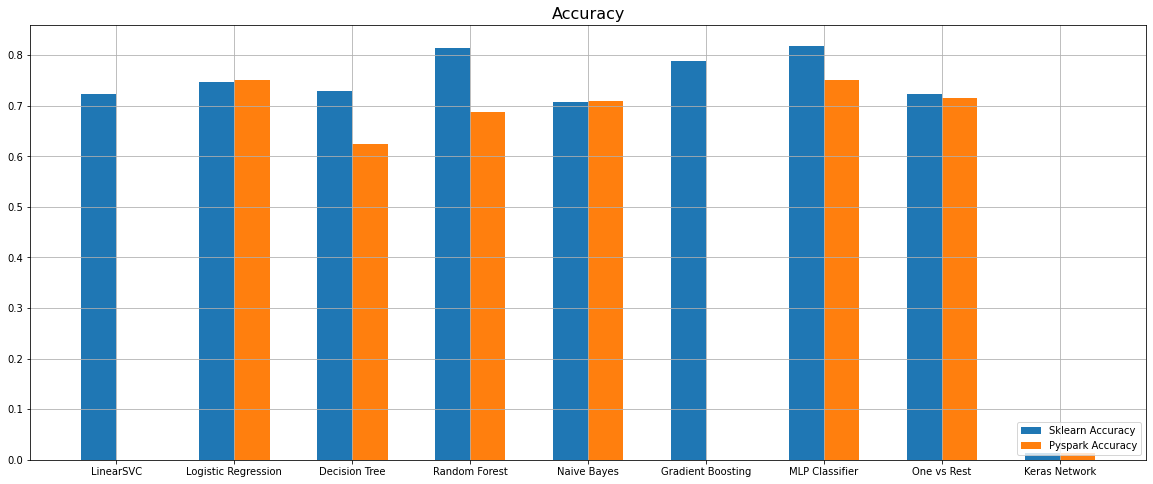

In [9]:
eval_methods.plot(sklearn_accuracy, pyspark_accuracy, "Accuracy")

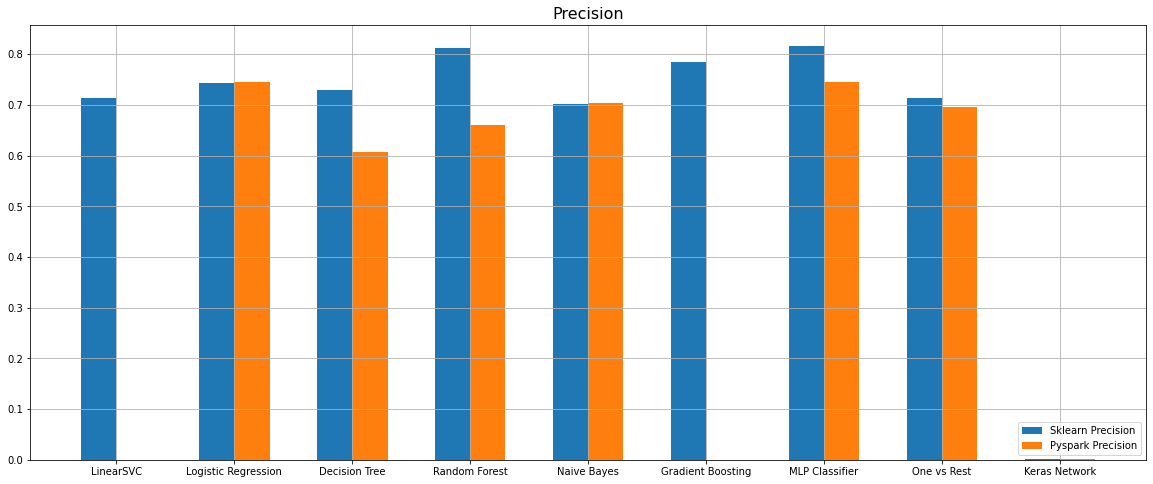

In [13]:
eval_methods.plot(sklearn_precision, pyspark_precision, "Precision")

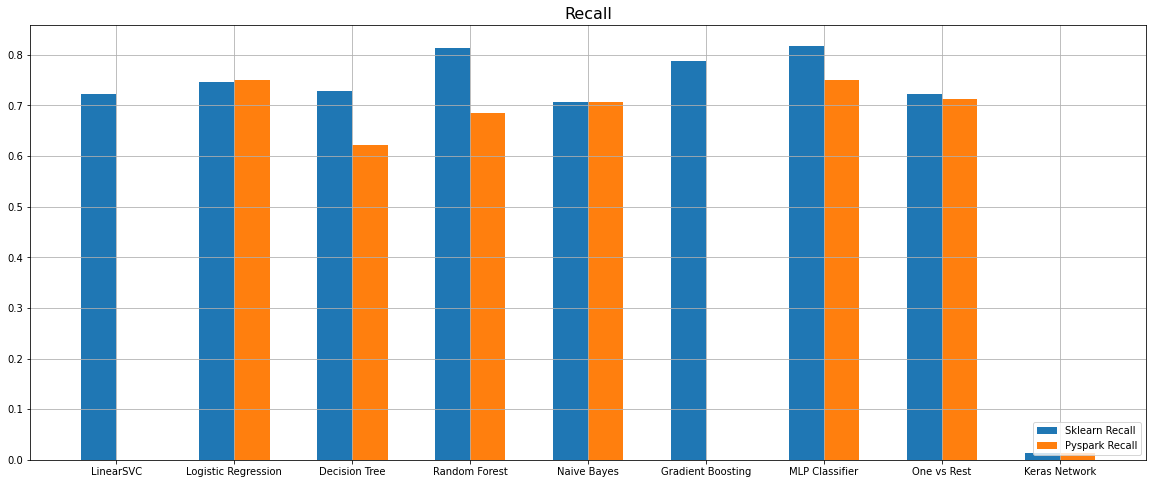

In [14]:
eval_methods.plot(sklearn_recall, pyspark_recall, "Recall")

* Hyperparameter tuning 
* Cross validation

* Scikit-Learn HyperParameters

In [12]:
grid = { 
    "LinearSVC": {
        "max_iter": [10, 50, 100, 500],
        "tol": [1e-2, 1e-3, 1e-4, 1e-5],
        "C": [0.1, 0.01, 0.001, 0.0001],
        "fit_intercept": [True, False]},
    "LogisticRegression": {
        "max_iter": [10, 50, 100, 500],
        "tol": [1e-2, 1e-3, 1e-4, 1e-5],
        "C": [0.1, 0.01, 0.001, 0.0001],
        "fit_intercept": [True, False]},
    "DecisionTreeClassifier": {
        "max_depth": [2, 5, 10, 20],
        "criterion": ["gini", "entropy"]},
    "RandomForestClassifier": {
        "bootstrap": [True, False],
        "max_depth": [2, 5, 10, 20],
        "criterion": ["gini", "entropy"],
        "n_estimators": [5, 10, 50, 100]},
    "GaussianNB": {
        "var_smoothing": [1e-07, 1e-08, 1e-09, 1e-10]},
    "GradientBoostingClassifier": {
        "max_features": ["auto", "sqrt", "log2"],
        "max_depth": [2, 5, 10, 20],
        "learning_rate": [0.1, 0.01, 0.001, 0.0001]},
    "MLPClassifier": {
        "tol": [1e-2, 1e-3, 1e-4, 1e-5],
        "max_iter": [10, 50, 100, 500],
        "batch_size": [8, 32, 128, 512]},
    "OneVsRestClassifier": {
        "n_jobs": [1, 3, 5, 7, 10]}}

PySpark Hyperparameres 

In [11]:
para = { 
    "LinearSVC": {
        "max_iter": ["maxIter"],
        "tol": ["tol"],
        "C": ["regParam"],
        "fit_intercept": ["fitIntercept"]},
    "LogisticRegression": {
        "max_iter": ["maxIter"],
        "tol": ["tol"],
        "C": ["regParam"],
        "fit_intercept": ["fitIntercept"]},
    "DecisionTreeClassifier": {
        "max_depth": ["maxDepth"],
        "criterion": ["impurity"]},
    "RandomForestClassifier": {
        "bootstrap": ["bootstrap"],
        "max_depth": ["maxDepth"],
        "criterion": ["impurity"],
        "n_estimators": ["numTrees"]},
    "GaussianNB": {
        "var_smoothing": ["smoothing"]},
    "GradientBoostingClassifier": {
        "max_features": ["featureSubsetStrategy"],
        "max_depth": ["maxDepth"],
        "learning_rate": ["stepSize"]},
    "MLPClassifier": {
        "tol": ["tol"],
        "max_iter": ["maxIter"],
        "batch_size": ["blockSize"]},
    "OneVsRestClassifier": {
        "n_jobs": ["parallelism"]}}

* K-Cross validation with K=5  
* Training, evaluting, and model saving takes long time for the optimized models takes an enourmous time
* Even to train evaluate and save a single classifier it takes around 10 to 15 minutes
* In total it takes around 2 hours to optimize the various hyperparameters, train the models, and save them

In [ ]:
sklearn_accuracy = []
sklearn_confusion = []
sklearn_roc = []
sklearn_precision = []
sklearn_recall = []

for clf in sklearn_classifiers:
    rf_cv = GridSearchCV(estimator=clf, param_grid=grid[str(clf)[:str(clf).find("(")]], cv= 5)
    rf_cv.fit(x_train, y_train)
    clf = clf.set_params(**rf_cv.best_params_)
    clf.fit(x_train, y_train)
    if not os.path.exists("./models/fashion/sklearn/"):
        os.makedirs("./models/fashion/sklearn/")
    pickle.dump(clf, open("./models/fashion/sklearn/"+str(clf)[:str(clf).find("(")]+".sav", 'wb'))
    for i, v in rf_cv.best_params_.items():
        para[str(clf)[:str(clf).find("(")]][i].append(v)
    print(str(clf)[:str(clf).find("(")], rf_cv.best_params_)
    accuracy, confusion, roc, precision, recall = eval_methods.eval(clf, y_test, clf.predict(x_test), ax, bx)
    sklearn_accuracy.append(accuracy)
    sklearn_confusion.append(confusion)
    sklearn_roc.append(roc)
    sklearn_precision.append(precision)
    sklearn_recall.append(recall)
    
clf = keras.Sequential()
clf.add(keras.layers.Dense(1024, activation='relu'))
clf.add(keras.layers.Dense(512, activation='relu'))
clf.add(keras.layers.Dense(128, activation='relu'))
clf.add(keras.layers.Dense(32, activation='relu'))
clf.add(keras.layers.Dense(10, activation='softmax'))

clf.compile(optimizer=keras.optimizers.Adam(),
            loss=keras.losses.SparseCategoricalCrossentropy(),
            metrics=keras.metrics.SparseCategoricalAccuracy())

clf.fit(x_train, y_train, verbose=0, epochs=50)
accuracy, confusion, roc, precision, recall = eval_methods.eval(clf, y_test, np.round(clf.predict(x_test, verbose=0))[:,0], ax, bx)
sklearn_accuracy.append(accuracy)
sklearn_confusion.append(confusion)
sklearn_roc.append(roc)
sklearn_precision.append(precision)
sklearn_recall.append(recall)


LinearSVC {'C': 0.1, 'fit_intercept': True, 'max_iter': 10, 'tol': 0.01}
LogisticRegression {'C': 0.1, 'fit_intercept': True, 'max_iter': 500, 'tol': 0.01}
DecisionTreeClassifier {'criterion': 'entropy', 'max_depth': 10}


In [ ]:
grid = {}
for i in para.keys():
    if i == "GaussianNB":
        grid["NaiveBayes"] = {}
        for j in para[i].values():
            grid["NaiveBayes"][j[0]] = j[1]
    elif i == "GradientBoostingClassifier":
        grid["GBTClassifier"] = {}
        for j in para[i].values():
            grid["GBTClassifier"][j[0]] = j[1]
    elif i == "MLPClassifier":
        grid["MultilayerPerceptronClassifier"] = {}
        for j in para[i].values():
            grid["MultilayerPerceptronClassifier"][j[0]] = j[1]
    elif i == "OneVsRestClassifier":
        grid["OneVsRest"] = {}
        for j in para[i].values():
            grid["OneVsRest"][j[0]] = j[1]
    else:
        grid[i] = {}
        for j in para[i].values():
            grid[i][j[0]] = j[1]

In [ ]:
pyspark_accuracy = []
pyspark_confusion = []
pyspark_roc = []
pyspark_precision = []
pyspark_recall = []
if os.path.exists("./models/fashion/pyspark/"):
    shutil.rmtree("./models/fashion/pyspark/", ignore_errors=True)
for clf in pyspark_classifiers:
    clf = clf.setParams(**grid[str(clf)[:str(clf).find("_")]])
    clf = clf.fit(train)
    if not os.path.exists("./models/fashion/pyspark/"):
        os.makedirs("./models/fashion/pyspark/")
    clf.save("./models/fashion/pyspark/"+str(clf)[:str(clf).find("_")])
    real = np.array([re.findall(r'\d+', str(x))  for x in clf.transform(test).select("label").collect()]).reshape(-1)
    pred = np.array([re.findall(r'\d+', str(x))  for x in clf.transform(test).select("prediction").collect()]).reshape(-1)[::2]
    accuracy, confusion, roc, precision, recall = eval_methods.eval(clf, real, pred, ax, bx)
    pyspark_accuracy.append(accuracy)
    pyspark_confusion.append(confusion)
    pyspark_roc.append(roc)
    pyspark_precision.append(precision)
    pyspark_recall.append(recall)
    
clf = keras.Sequential()
clf.add(keras.layers.Dense(1024, activation='relu'))
clf.add(keras.layers.Dense(512, activation='relu'))
clf.add(keras.layers.Dense(128, activation='relu'))
clf.add(keras.layers.Dense(32, activation='relu'))
clf.add(keras.layers.Dense(10, activation='softmax'))

clf.compile(optimizer=keras.optimizers.Adam(),
            loss=keras.losses.SparseCategoricalCrossentropy(),
            metrics=keras.metrics.SparseCategoricalAccuracy())

clf.fit(x_train, y_train, verbose=0, epochs=50)
clf.save("./models/fashion/keras.h5")
accuracy, confusion, roc, precision, recall = eval_methods.eval(clf, y_test, np.round(clf.predict(x_test, verbose=0))[:,0], ax, bx)
pyspark_accuracy.append(accuracy)
pyspark_confusion.append(confusion)
pyspark_roc.append(roc)
pyspark_precision.append(precision)
pyspark_recall.append(recall)

In [ ]:
pyspark_accuracy[-1]

In [ ]:
pyspark_accuracy.insert(0, 0)
pyspark_accuracy.insert(5, 0)
pyspark_confusion.insert(0, 0)
pyspark_confusion.insert(5, 0)
pyspark_precision.insert(0, 0)
pyspark_precision.insert(5, 0)
pyspark_recall.insert(0, 0)
pyspark_recall.insert(5, 0)

In [ ]:
eval_methods.plot(sklearn_accuracy, pyspark_accuracy, "Accuracy")

In [ ]:
eval_methods.plot(sklearn_precision, pyspark_precision, "Precision")

In [ ]:
eval_methods.plot(sklearn_recall, pyspark_recall, "Recall")

In [ ]:
eval_methods.plot(sklearn_roc, pyspark_roc, "Roc")